<a href="https://colab.research.google.com/github/garthajon/CPLUS_QUANT/blob/main/ZSCORE_WEEKY_GARCH_PREDICTION_USING_MONTECARLO_SIM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.3/978.3 kB 26.7 MB/s eta 0:00:00


/tmp/ipython-input-2178813804.py:20: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers, start=start_date, end=end_date, progress=False)['Close']
/tmp/ipython-input-2178813804.py:58: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  last_cond_vol_percent = res.conditional_volatility[-1]  # percent units (e.g. 1.5)
/tmp/ipython-input-2178813804.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  last_resid_percent = res.resid[-1]  # residual in percent units since we fit on percent returns


PLTR simulation done — produced 2000 simulated weekly z-score paths.


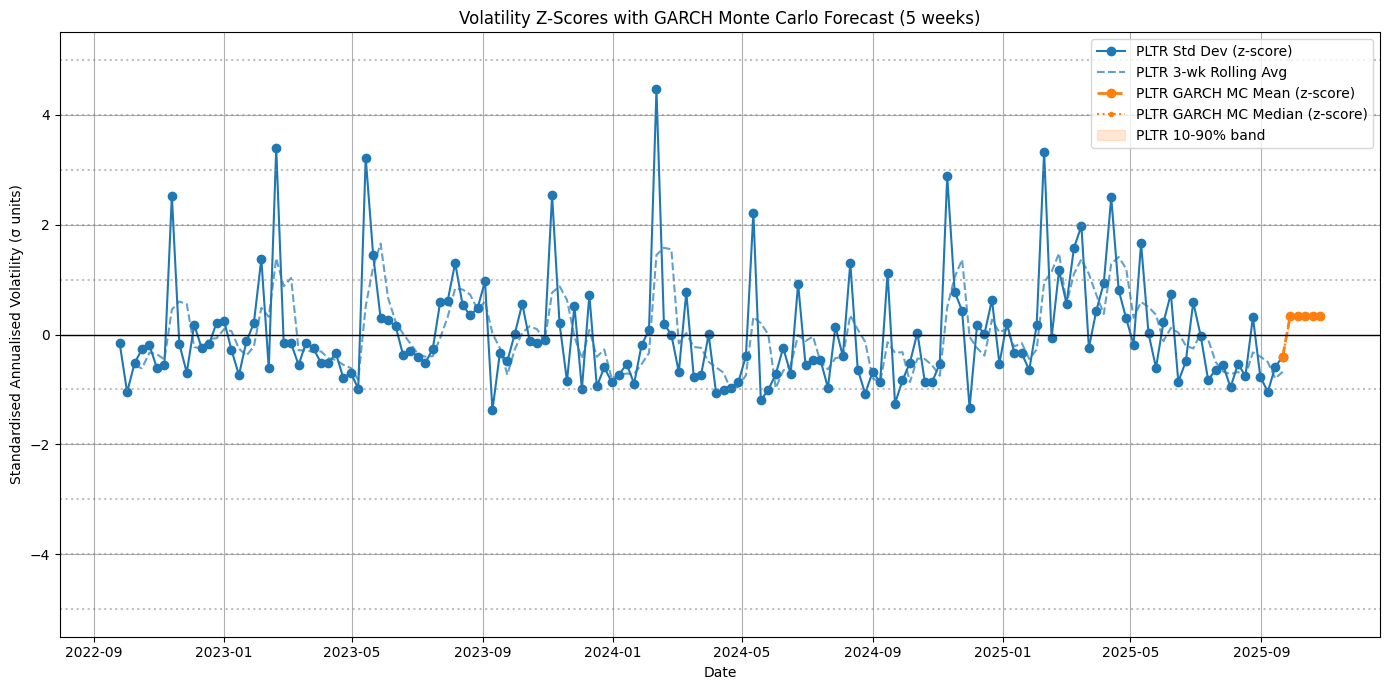

In [5]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model

# -------- PARAMETERS --------
tickers = ['PLTR']
end_date = pd.Timestamp.today()
start_date = end_date - pd.DateOffset(years=3)
n_weeks = 5
trading_days_per_week = 5
horizon_days = n_weeks * trading_days_per_week  # 25 days
n_sims = 2000   # Monte Carlo paths (increase if you want smoother quantiles)
random_seed = 42

np.random.seed(random_seed)

# -------- FETCH DATA --------
df = yf.download(tickers, start=start_date, end=end_date, progress=False)['Close']
returns = df.pct_change().dropna()  # decimals (0.01 = 1%)

# -------- HISTORICAL WEEKLY REALISED VOL & Z-SCORE --------
weekly_std = returns.resample('W').std() * np.sqrt(252)   # weekly annualised vol, decimal units
standardised = pd.DataFrame(index=weekly_std.index)
zscore_params = {}

for t in tickers:
    mu = weekly_std[t].mean()
    sigma = weekly_std[t].std(ddof=0)  # population std for consistency with prior code
    standardised[t] = (weekly_std[t] - mu) / sigma
    zscore_params[t] = (mu, sigma)

rolling_avg3 = standardised.rolling(window=3, min_periods=3).mean()

# -------- FIT GARCH & MONTE CARLO SIMULATION (manual recursion) --------
# We'll fit on returns * 100 (percent) which is common; keep track of units carefully.
results_store = {}

for ticker in tickers:
    # Fit GARCH(1,1) on percent returns
    am = arch_model(returns[ticker] * 100, vol='Garch', p=1, q=1, mean='Constant')
    res = am.fit(disp='off')

    # Extract params — names usually: 'mu', 'omega', 'alpha[1]', 'beta[1]'
    params = res.params
    # safe extraction with defaults if names differ
    omega = params['omega'] if 'omega' in params.index else params.get('omega', None)
    alpha = params['alpha[1]'] if 'alpha[1]' in params.index else params.get('alpha', None)
    beta  = params['beta[1]']  if 'beta[1]' in params.index else params.get('beta', None)
    if omega is None or alpha is None or beta is None:
        # try positional fallback (mu, omega, alpha[1], beta[1])
        omega = params.iloc[1]
        alpha = params.iloc[2]
        beta  = params.iloc[3]

    # Starting values: last observed sigma (in percent) and last residual (in percent)
    last_cond_vol_percent = res.conditional_volatility[-1]  # percent units (e.g. 1.5)
    last_resid_percent = res.resid[-1]  # residual in percent units since we fit on percent returns

    # Prepare storage for weekly aggregated results across sims
    weekly_z_sims = np.zeros((n_sims, n_weeks))

    for sim in range(n_sims):
        sigma = last_cond_vol_percent  # start sigma in percent
        eps = last_resid_percent       # start residual in percent
        daily_sigma_path = np.zeros(horizon_days)

        for day in range(horizon_days):
            # GARCH(1,1) recursion for variance (percent^2 units)
            var_next = omega + alpha * (eps ** 2) + beta * (sigma ** 2)
            sigma_next = np.sqrt(max(var_next, 0.0))  # percent
            # draw innovation in percent units
            z = np.random.normal()
            eps = sigma_next * z
            sigma = sigma_next
            daily_sigma_path[day] = sigma  # percent

        # Convert percent -> decimal
        daily_sigma_decimal = daily_sigma_path / 100.0  # e.g. 1.5% -> 0.015

        # Aggregate into weekly annualised vols (per week)
        week_vols = []
        for w in range(n_weeks):
            start = w * trading_days_per_week
            end = start + trading_days_per_week
            slice_d = daily_sigma_decimal[start:end]
            if len(slice_d) == 0:
                break
            # rms of daily sigmas then annualise
            week_vol = np.sqrt(np.mean(slice_d ** 2)) * np.sqrt(252)
            week_vols.append(week_vol)

        week_vols = np.array(week_vols)  # decimal units like weekly_std
        # convert to z-scores using historical mu/sigma
        mu, sigma_hist = zscore_params[ticker]
        week_z = (week_vols - mu) / sigma_hist
        weekly_z_sims[sim, :] = week_z

    # Save results: mean, median, quantiles across sims (per week)
    q10 = np.percentile(weekly_z_sims, 10, axis=0)
    q25 = np.percentile(weekly_z_sims, 25, axis=0)
    q50 = np.percentile(weekly_z_sims, 50, axis=0)
    q75 = np.percentile(weekly_z_sims, 75, axis=0)
    q90 = np.percentile(weekly_z_sims, 90, axis=0)
    mean_z = np.mean(weekly_z_sims, axis=0)

    results_store[ticker] = {
        'mean': mean_z, 'median': q50, 'q10': q10, 'q25': q25, 'q75': q75, 'q90': q90,
        'all_sims': weekly_z_sims
    }

    print(f"{ticker} simulation done — produced {n_sims} simulated weekly z-score paths.")

# -------- PLOT: actual z-scores + forecast continuing from last point + quantile bands --------
plt.figure(figsize=(14,7))
colors = plt.cm.tab10.colors

for i, ticker in enumerate(tickers):
    # historical
    plt.plot(standardised.index, standardised[ticker], marker='o', color=colors[i], label=f'{ticker} Std Dev (z-score)')
    plt.plot(rolling_avg3.index, rolling_avg3[ticker], linestyle='--', color=colors[i], alpha=0.7, label=f'{ticker} 3-wk Rolling Avg')

    # last actual point
    last_actual = standardised[ticker].iloc[-1]
    last_date = standardised.index[-1]

    # forecast week index: start at last_date (so line is continuous) then next n_weeks
    forecast_index = pd.date_range(last_date, periods=n_weeks+1, freq='W')  # includes last_date
    # build series starting with last actual then mean forecasts
    mean_series = np.concatenate([[last_actual], results_store[ticker]['mean']])
    median_series = np.concatenate([[last_actual], results_store[ticker]['median']])
    q10_series = np.concatenate([[last_actual], results_store[ticker]['q10']])
    q90_series = np.concatenate([[last_actual], results_store[ticker]['q90']])

    # plot mean/median forecast line (distinct colour: shift palette)
    forecast_color = colors[(i+1) % len(colors)]
    plt.plot(forecast_index, mean_series, linestyle='--', color=forecast_color, linewidth=2, marker='o', label=f'{ticker} GARCH MC Mean (z-score)')
    plt.plot(forecast_index, median_series, linestyle=':', color=forecast_color, linewidth=1.5, marker='.', label=f'{ticker} GARCH MC Median (z-score)')

    # shaded quantile band between q10 and q90 (use semi-transparent fill)
    plt.fill_between(forecast_index, q10_series, q90_series, color=forecast_color, alpha=0.18, label=f'{ticker} 10-90% band')

# aesthetics
plt.axhline(0, color='black', linestyle='-', linewidth=1)
for k in range(1,6):
    plt.axhline(k, color='grey', linestyle=':', alpha=0.5)
    plt.axhline(-k, color='grey', linestyle=':', alpha=0.5)

plt.title(f'Volatility Z-Scores with GARCH Monte Carlo Forecast ({n_weeks} weeks)')
plt.xlabel('Date')
plt.ylabel('Standardised Annualised Volatility (σ units)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
